# Project 2: Applying an MLP
Cody Uhl and Jaxon Ham
Fall 2025

### Configs and Imports

In [10]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

from pathlib import Path
import joblib
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Paths
TRAIN_PATH = "project_adult.csv"
VALID_PATH = "project_validation_inputs.csv"

# === CHANGE THIS BEFORE EXPORTING ===
GROUP_NUMBER = "05"
OUT_DIR = Path("./artifacts_part1")
OUT_DIR.mkdir(parents=True, exist_ok=True)

PRED_CSV = OUT_DIR / f"Group_{GROUP_NUMBER}_MLP_PredictedOutputs.csv"
BEST_PIPE_PATH = OUT_DIR / "best_mlp_pipeline.joblib"
TRANSFORMER_ONLY_PATH = OUT_DIR / "preprocess_only.joblib"

print("Using data:", TRAIN_PATH, "and", VALID_PATH)
print("Outputs will be saved under:", OUT_DIR.resolve())


Using data: project_adult.csv and project_validation_inputs.csv
Outputs will be saved under: /Users/codyuhl/Documents/Classes/Current/DASC41103_ML/Project_2/artifacts_part1


## Load Raw Data

In [11]:
df = pd.read_csv(TRAIN_PATH)
df_valid = pd.read_csv(VALID_PATH)

print("Train shape:", df.shape)
print("Validation shape:", df_valid.shape)
display(df.head(5))
display(df_valid.head(5))

# Per your note: target is explicitly named 'income'
TARGET = "income"
assert TARGET in df.columns, "Expected a column named 'income'."


Train shape: (26048, 16)
Validation shape: (6513, 15)


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


## Basic Cleaning
(Normalize Missing Tokens, Trim Whitespace)

In [12]:
def normalize_missing(dfx: pd.DataFrame) -> pd.DataFrame:
    """
    Replace '?' and blanks with NaN; strip whitespace in object-like columns,
    and ensure they remain dtype 'object' (not pandas 'string' dtype).
    """
    dfx = dfx.copy()

    # First, standardize obvious '?' tokens globally
    dfx = dfx.replace(["?", " ?"], np.nan)

    # Work only on object-like columns and keep them as object dtype
    obj_cols = dfx.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        col = dfx[c]
        # strip only on non-null entries
        mask = col.notna()
        col_vals = col.astype(str)
        col_vals.loc[mask] = col_vals.loc[mask].str.strip()
        # empty strings => NaN
        col_vals.replace({"": np.nan, "?": np.nan, " ?": np.nan}, inplace=True)
        dfx[c] = col_vals.astype("object")  # <-- keep as 'object', not 'string'

    return dfx


df = normalize_missing(df)
df_valid = normalize_missing(df_valid)

# Split features/target
y_raw = df[TARGET].copy()
X = df.drop(columns=[TARGET]).copy()
X_valid = df_valid.copy()

X.shape, X_valid.shape


((26048, 15), (6513, 15))

## Encode Target
(1 for >50k, 0 otherwise)

In [13]:
def encode_income_to_binary(y: pd.Series) -> pd.Series:
    ys = y.astype("string").str.strip().str.lower()
    positives = {">50k", ">50k."}
    return ys.isin(positives).astype(int)

y = encode_income_to_binary(y_raw)
print("Target distribution (0/1):")
display(y.value_counts().rename("count").to_frame())


Target distribution (0/1):


,count
income,
0,19778
1,6270


## Train/Test Split (Stratified)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Shapes:",
      "\nX_train:", X_train.shape, " y_train:", y_train.shape,
      "\nX_test :", X_test.shape,  " y_test :", y_test.shape)

print("\nClass balance (train/test):")
print(y_train.value_counts(normalize=True).rename("train").round(3).to_frame())
print(y_test.value_counts(normalize=True).rename("test").round(3).to_frame())


Shapes: 
X_train: (20838, 15)  y_train: (20838,) 
X_test : (5210, 15)  y_test : (5210,)

Class balance (train/test):
        train
income       
0       0.759
1       0.241
         test
income       
0       0.759
1       0.241


## Preprocessing Transformer
Impute > Scale (numeric)

Impute > One-Hot (categorical)

In [15]:
# Identify numeric vs categorical based on X_train (post-cleaning)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # sparse-safe
])

categorical_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                                   ("onehot", OneHotEncoder(handle_unknown="ignore"))])

transformers = []
if len(num_cols) > 0:
    transformers.append(("num", numeric_pipe, num_cols))
if len(cat_cols) > 0:
    transformers.append(("cat", categorical_pipe, cat_cols))

# If one of the lists is empty, the transformer for that block simply won't be added
preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=1.0,
    verbose_feature_names_out=False
)

print("num_cols:", len(num_cols), "cat_cols:", len(cat_cols))
print(preprocess)



num_cols: 7 cat_cols: 8
ColumnTransformer(sparse_threshold=1.0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['Unnamed: 0', 'age', 'fnlwgt',
                                  'education-num', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'educatio

## Train Multiple MLP Candidates via GridSearchCV

In [16]:
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("mlp", MLPClassifier(
        max_iter=300, random_state=42,
        early_stopping=True, n_iter_no_change=10
    ))
])

# Modest grid for runtime; expand if you have time
param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-3, 5e-4],
    "mlp__solver": ["adam"],  # 'adam' is robust for larger data; 'lbfgs' omitted for stability
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=1,
    return_train_score=True
)

mlp_gs.fit(X_train, y_train)
print("Best params:", mlp_gs.best_params_)
print("Best CV accuracy:", round(mlp_gs.best_score_, 4))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
Best CV accuracy: 0.8537


## Evaluate Model Performance on Holdout Test Set

In [17]:
best_pipe = mlp_gs.best_estimator_
y_pred_test = best_pipe.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
print("Holdout Test Accuracy:", round(test_acc, 4))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test, digits=4))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))

# Show the top CV results
cv_results = pd.DataFrame(mlp_gs.cv_results_)
display(cv_results.sort_values("mean_test_score", ascending=False).head(10))


Holdout Test Accuracy: 0.8495

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.8812    0.9267    0.9034      3956
           1     0.7238    0.6061    0.6597      1254

    accuracy                         0.8495      5210
   macro avg     0.8025    0.7664    0.7816      5210
weighted avg     0.8434    0.8495    0.8447      5210

Confusion Matrix (Test):
[[3666  290]
 [ 494  760]]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__learning_rate_init,param_mlp__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
20,7.878356,1.646888,0.107958,0.085120,relu,0.0100,"(64, 32)",0.0010,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.01...",0.848608,0.851967,0.856046,0.849292,0.862731,0.853729,0.005204,1,0.858188,0.863587,0.859088,0.860236,0.867135,0.861647,0.003298
11,9.655006,5.264433,0.064913,0.028669,relu,0.0010,"(128,)",0.0005,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.850768,0.849808,0.851727,0.853852,0.861051,0.853441,0.004034,2,0.855729,0.865627,0.855609,0.852618,0.866295,0.859176,0.005655
18,9.424921,2.692830,0.072083,0.014957,relu,0.0100,"(128,)",0.0010,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.01...",0.851967,0.850048,0.847889,0.853852,0.862731,0.853297,0.005116,3,0.866527,0.867906,0.855609,0.862396,0.863356,0.863159,0.004278
15,11.013793,1.974914,0.052963,0.010727,relu,0.0010,"(128, 64)",0.0005,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.854127,0.849328,0.852447,0.852892,0.856971,0.853153,0.002479,4,0.856209,0.864067,0.866407,0.861856,0.858857,0.861479,0.003627
19,10.584335,4.179670,0.078884,0.052120,relu,0.0100,"(128,)",0.0005,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.01...",0.852207,0.849328,0.851008,0.854332,0.858171,0.853009,0.003053,5,0.855849,0.864487,0.855249,0.858977,0.859337,0.858780,0.003286
31,14.454170,4.934373,0.078916,0.027138,tanh,0.0001,"(128, 64)",0.0005,adam,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",0.850528,0.845489,0.849808,0.856971,0.862011,0.852962,0.005825,6,0.853029,0.857229,0.855429,0.861616,0.857537,0.856968,0.002824
46,17.223438,5.801134,0.083337,0.016062,tanh,0.0100,"(128, 64)",0.0010,adam,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.01...",0.851008,0.846689,0.850768,0.856251,0.860091,0.852961,0.004683,7,0.866107,0.853869,0.857708,0.862876,0.859217,0.859955,0.004219
12,5.243299,0.813090,0.048722,0.013180,relu,0.0010,"(64, 32)",0.0010,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.849808,0.851727,0.854367,0.847852,0.860571,0.852865,0.004414,8,0.858248,0.865147,0.859688,0.856457,0.860056,0.859919,0.002904
3,8.684720,4.276211,0.082021,0.030698,relu,0.0001,"(128,)",0.0005,adam,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",0.851008,0.847889,0.851727,0.854812,0.858651,0.852817,0.003654,9,0.855969,0.865327,0.855549,0.852738,0.857357,0.857388,0.004244
39,13.630506,4.948867,0.085158,0.020013,tanh,0.0010,"(128, 64)",0.0005,adam,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",0.850528,0.845250,0.849328,0.856731,0.861771,0.852722,0.005833,10,0.853029,0.857169,0.855249,0.862036,0.857537,0.857004,0.002984


Holdout ROC-AUC: 0.9085
Holdout PR-AUC (AP): 0.7744


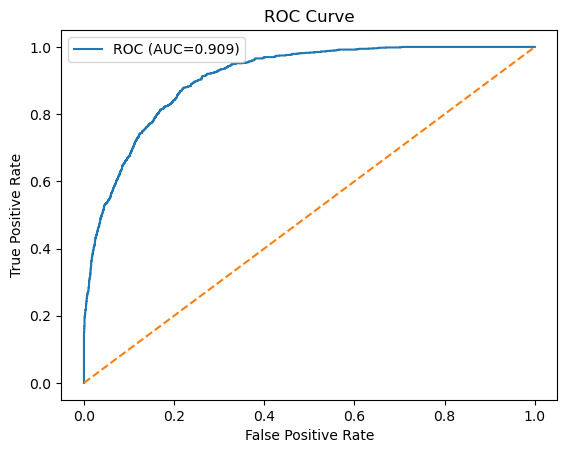

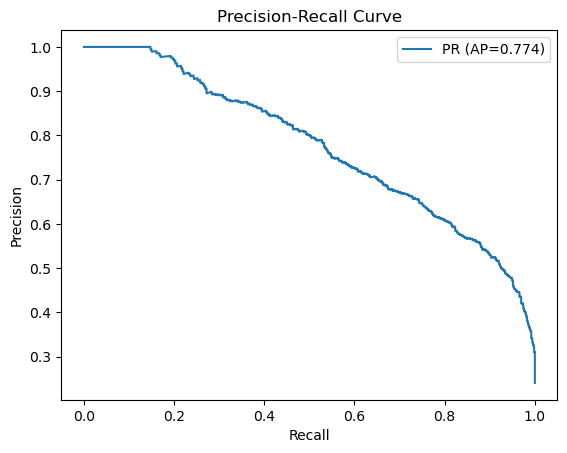

In [18]:
y_proba_test = best_pipe.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_test)
ap = average_precision_score(y_test, y_proba_test)
print(f"Holdout ROC-AUC: {roc_auc:.4f}")
print(f"Holdout PR-AUC (AP): {ap:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure()
plt.plot(rec, prec, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.show()


## Updating to Correct Format (1,-1) and Saving Predictions

In [19]:
# Predict on validation inputs
valid_pred_binary = best_pipe.predict(X_valid)  # 0/1
valid_pred_signed = np.where(valid_pred_binary == 1, 1, -1)  # map to 1 / -1 per spec

pred_df = pd.DataFrame(valid_pred_signed, columns=["Prediction"])
pred_df.to_csv(PRED_CSV, index=False)
print("Validation predictions saved to:", PRED_CSV.resolve())

# Preview
display(pred_df.head(10))


Validation predictions saved to: /Users/codyuhl/Documents/Classes/Current/DASC41103_ML/Project_2/artifacts_part1/Group_05_MLP_PredictedOutputs.csv


,Prediction
0,-1
1,1
2,1
3,-1
4,-1
5,1
6,1
7,-1
8,-1
9,1
